## 데이터 세트 종류 확인

In [1]:
import re, json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
PATH = '/home/ai-sjjy/workspace/juyoung/airBNB/dataset/'

In [3]:
AGE_GENDER = 'age_gender_bkts.csv'
COUNTRIY = 'countries.csv'
SESSIONS = 'sessions.csv'

TRAIN_USERS = 'train_users_2.csv'
TEST_USERS = 'test_users.csv'

SAMPLE = 'sample_submission_NDF.csv'

In [4]:
age_df = pd.read_csv(PATH + AGE_GENDER)
country_df = pd.read_csv(PATH + COUNTRIY)
session_df = pd.read_csv(PATH + SESSIONS)

train_df = pd.read_csv(PATH + TRAIN_USERS)
test_df = pd.read_csv(PATH + TEST_USERS)

sample_df = pd.read_csv(PATH + SAMPLE)

##### [1-1] 구조 확인 (속성)

In [5]:
train_df.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
test_df.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


* train_data 속성

**id** : 유저 id <br>
**date_account_created** : 계정 생성 날짜<br>
**timestamp_first_active** :  처음 활동한 날짜  (이 feature는 계정 생성 or  첫 예약 날짜보다 이전일 것입니다)<br>
**date_first_booking** : 첫 예약한 날짜<br>
**gender** : 성별<br>
**age** : 나이<br>
**signup_method** : 회원가입 방법<br>
**signup_flow** : 회원가입할 때 사용자가 보고있는 page 번호<br>
**language** : 선호 언어, 사용 언어(모국어)<br>
**affiliate_channel** : Airbnb 유입경로<br>
**affiliate_provider** : 유입 장소 (google, craigslist, other)<br>
**first_affiliate_tracked** : 회원가입 전 user가 반응한 첫번째 marketing<br>
**signup_app** : Web , iOS, Android etc<br>
**first_device_type** : Window/Mac desktop , iPhone etc<br>
**first_browser** : Chrome, Safari, Firefox etc<br>
**country_destination** : 첫 예약 국가 / 우리가 예측해야하는 target 변수<br>

## 데이터 분석

##### [1] 데이터 개수 확인

In [7]:
print(len(train_df))
print(len(test_df))

213451
62096


##### [2] 정답 데이터 : country_destination 확인

In [8]:
print("정답(country_destination)의 속성 값 종류 : ", train_df.country_destination.unique())

정답(country_destination)의 속성 값 종류 :  ['NDF' 'US' 'other' 'FR' 'CA' 'GB' 'ES' 'IT' 'PT' 'NL' 'DE' 'AU']


In [9]:
train_df = train_df[~train_df['country_destination'].isnull()]

In [10]:
print("정답(country_destination)의 nan 제거 결과 : ", len(train_df[train_df['country_destination'].isnull()]))

정답(country_destination)의 nan 제거 결과 :  0


/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


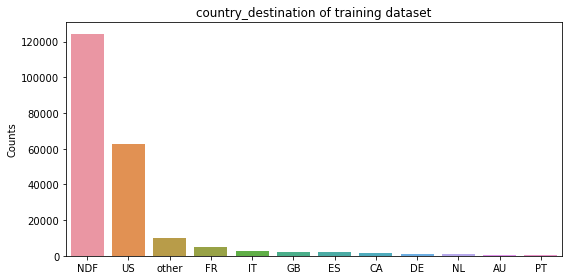

In [11]:
feat_train = train_df['country_destination'].value_counts()
fig = plt.figure(figsize=(8,4))
sns.barplot(feat_train.index.values, feat_train.values)
plt.title('country_destination of training dataset')
plt.ylabel('Counts')
plt.tight_layout()

##### => NDF가 굉장히 많은 값을 차지하고 있다ㅏ

##### [3] 먼저 어떤 속성에 결측치가 존재하는지 확인

In [12]:
train_df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [13]:
test_df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

*  그 결과 : date_first_booking, age, first_affiliate_tracked에 결측지 존재한다는 것을 알았다
* 이 값을 어떻게 처리할 지 분석을 통해 진행해야 한다

### [1] AGE

##### [1-2] age에 대한 값 조정

- airBNB는 신규 사용자가 첫 여행 경험을 어디서(목적지)로 예약할 것인지 예측하는 문제이다
- 그렇기 때문에 사실 상 나이가 18 미만, 100 초과인 사람은 본인이 예약한 것이 아니기 때문에 중요치 않다
- 그래서 (18 ~ 100)사이 나이를 가지지 않은 사람을 nan으로 업데이트 해준다.
- 그리고 지금 추천을 해주는 것이기 때문에 사람과 관련된 속성을 함부로 제거하면 안된다

In [14]:
train_df.loc[~train_df['age'].between(18, 100), 'age'] = np.nan
test_df.loc[~test_df['age'].between(18, 100), 'age'] = np.nan

In [15]:
print("train age : ", train_df['age'].isnull().sum()) # 87990 -> 90493
print("train age : ", test_df['age'].isnull().sum()) # 28876 -> 29251

train age :  90493
train age :  29251


##### [1-1] AGE(데이터 시각화)

In [16]:
age_groups_train = [
    train_df[train_df.age.isnull()],
    train_df.query('age >= 18 & age < 25'),
    train_df.query('age >= 25 & age < 35'),
    train_df.query('age >= 35 & age < 45'),
    train_df.query('age >= 45 & age < 55'),
    train_df.query("age >= 55 & age < 65"),
    train_df.query("age >= 65 & age < 75"),
    train_df.query("age >= 75 & age < 85"),
    train_df.query('age >= 85')
]

age_groups_test = [
    test_df[test_df.age.isnull()],
    test_df.query('age >= 18 & age < 25'),
    test_df.query('age >= 25 & age < 35'),
    test_df.query('age >= 35 & age < 45'),
    test_df.query('age >= 45 & age < 55'),
    test_df.query("age >= 55 & age < 65"),
    test_df.query("age >= 65 & age < 75"),
    test_df.query("age >= 75 & age < 85"),
    test_df.query('age >= 85')
]

/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'counts')

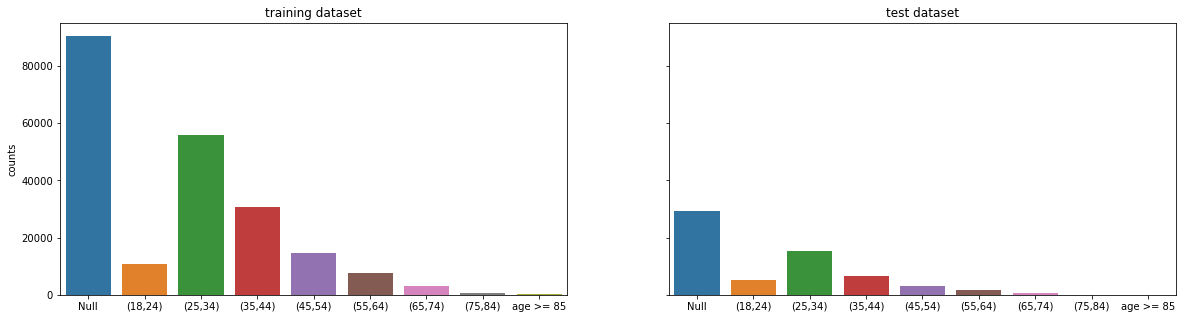

In [17]:
age_train = [age_group.age.shape[0] for age_group in age_groups_train]

age_test = [age_group.age.shape[0] for age_group in age_groups_test]

columns = ['Null', '(18,24)','(25,34)','(35,44)','(45,54)','(55,64)','(65,74)','(75,84)', 'age >= 85']

# plot
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey = True,figsize=(20,5))

sns.barplot(columns, age_train, ax = ax1)
sns.barplot(columns, age_test, ax = ax2)

ax1.set_title('training dataset')
ax2.set_title('test dataset')
ax1.set_ylabel('counts')

/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

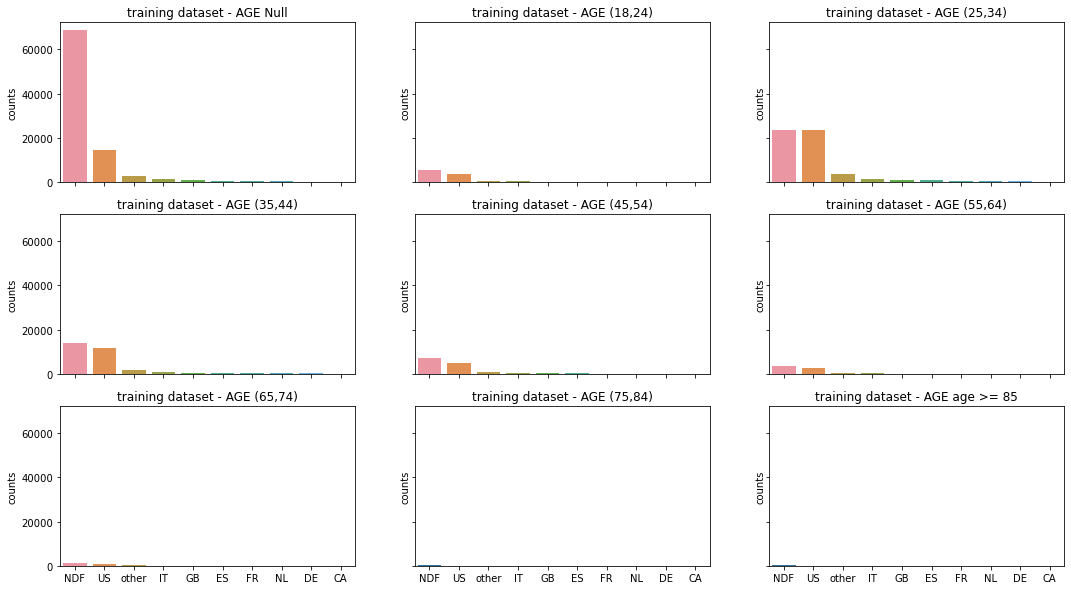

In [18]:
# subplot을 이용해 시각화 진행
age_train = [age_group['country_destination'].value_counts() for age_group in age_groups_train]

columns = ['Null', '(18,24)','(25,34)','(35,44)','(45,54)','(55,64)','(65,74)','(75,84)', 'age >= 85']

fig, axes = plt.subplots(3,3, sharex=True, sharey = True,figsize=(18,10))

for idx, age_group in enumerate(age_train):
    x, y = idx//3, idx%3
    sns.barplot(age_group.index.values, age_group.values, ax = axes[x, y]) # 가로 : 목적지\
    axes[x, y].set_title('training dataset - AGE '+columns[idx])
    axes[x, y].set_ylabel('counts')

* 25 ~ 34 나이 : 가장 많이 여행 다님 + [NDF -> US -> Other]
* 35 ~ 44 : 두 번째로 가장 많이 여행 다님 + [NDF -> US -> Other]

* 대부분 연령대가 [NDF -> US -> Other] 순으로 많이 여행 감

=> 이를 통해 나이가 여행지를 선택할 때 영향을 준다는 것을 알 수 있다.

### [3] GENDER 

In [19]:
print("train gender의 속성 값 종류 : ", train_df.gender.unique())
print("test gender의 속성 값 종류 : ", test_df.gender.unique())

train gender의 속성 값 종류 :  ['-unknown-' 'MALE' 'FEMALE' 'OTHER']
test gender의 속성 값 종류 :  ['FEMALE' '-unknown-' 'MALE' 'OTHER']


##### [3-1] GENDER 시각화

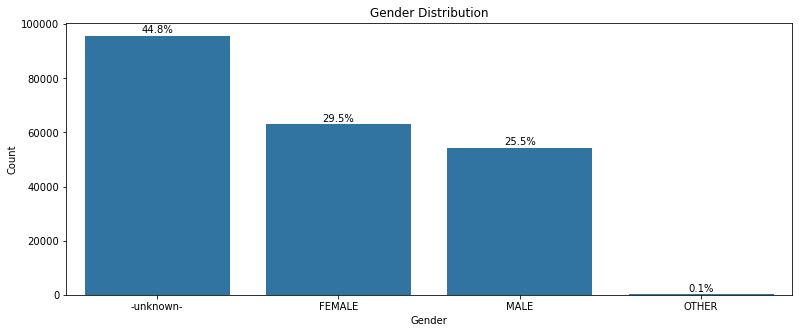

In [20]:
plt.figure(figsize=(13,5))
gender_feature = train_df['gender'].value_counts().index
sns.countplot(data = train_df, x = 'gender', order = gender_feature, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
gender_feature2 = train_df['gender'].value_counts()

for i in range(gender_feature2.shape[0]):
    count = gender_feature2[i]
    strt='{:0.1f}%'.format(100*count / train_df.shape[0])
    plt.text(i,count+1000,strt,ha='center')

(array([0, 1, 2, 3]),
 [Text(0, 0, '-unknown-'),
  Text(1, 0, 'MALE'),
  Text(2, 0, 'FEMALE'),
  Text(3, 0, 'OTHER')])

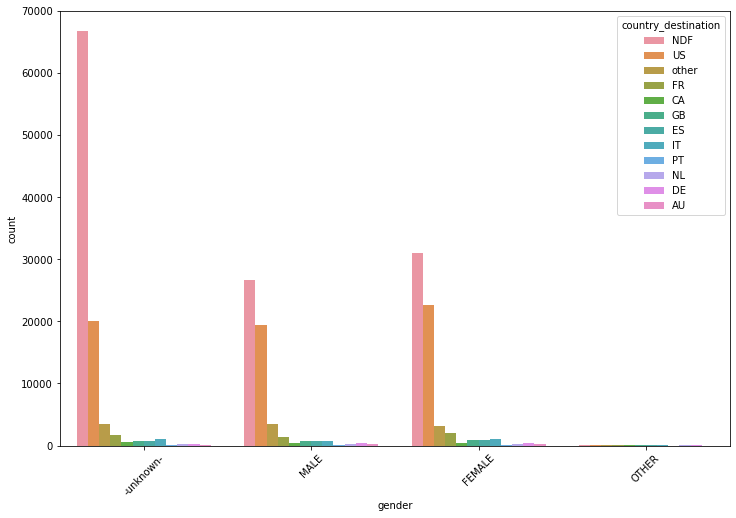

In [21]:
plt.figure(figsize=(12, 8))
sns.countplot(x=train_df['gender'], hue='country_destination',
              data=train_df)
plt.xticks(rotation=45)

In [22]:
train_df.loc[train_df['gender'] == '-unknown-', 'gender'] = 'OTHER'
test_df.loc[test_df['gender'] == '-unknown-', 'gender'] = 'OTHER'

### [4] date_first_booking

* print(len(test_df)) == TEST의 date_first_booking 결측 치 값과 동일하다
* 이는 이 값을 빼도 아무런 지정이 없다는 것이다 => 이 속성을 제거한다.

In [23]:
train_df = train_df.drop("date_first_booking", axis=1)
test_df = test_df.drop("date_first_booking", axis=1)

In [24]:
train_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination'],
      dtype='object')

In [25]:
test_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser'],
      dtype='object')

### [5] first_browser

In [26]:
print(" train first_browser : ", train_df.first_browser.unique())
print()
print(" train first_browser : ", test_df.first_browser.unique())

 train first_browser :  ['Chrome' 'IE' 'Firefox' 'Safari' '-unknown-' 'Mobile Safari'
 'Chrome Mobile' 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Mobile Firefox' 'Opera' 'TenFourFox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Maxthon'
 'Kindle Browser' 'CoolNovo' 'Conkeror' 'wOSBrowser' 'Google Earth'
 'Crazy Browser' 'Mozilla' 'OmniWeb' 'PS Vita browser' 'NetNewsWire'
 'CometBird' 'Comodo Dragon' 'Flock' 'Pale Moon' 'Avant Browser'
 'Opera Mobile' 'Yandex.Browser' 'TheWorld Browser' 'SlimBrowser' 'Epic'
 'Stainless' 'Googlebot' 'Outlook 2007' 'IceDragon']

 train first_browser :  ['Mobile Safari' 'Chrome' 'IE' 'Safari' '-unknown-' 'Firefox'
 'Chrome Mobile' 'Android Browser' 'IE Mobile' 'BlackBerry Browser'
 'Opera' 'Silk' 'Mobile Firefox' 'AOL Explorer' 'SeaMonkey' 'Opera Mobile'
 'wOSBrowser' 'Chromium' 'Apple Mail' 'Maxthon' 'IBrowse' 'Sogou Ex

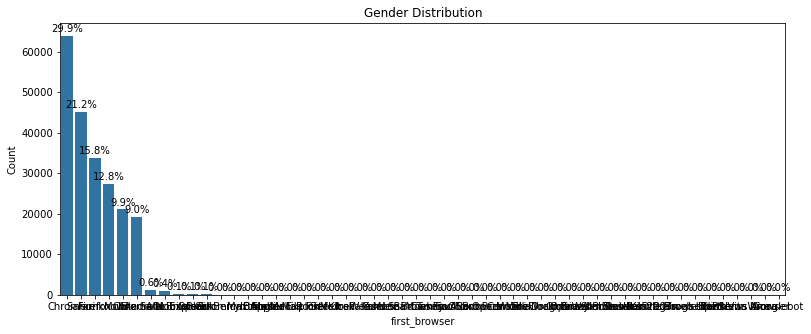

In [27]:
plt.figure(figsize=(13,5))
gender_feature = train_df['first_browser'].value_counts().index
sns.countplot(data = train_df, x = 'first_browser', order = gender_feature, color = sns.color_palette()[0])
plt.xlabel('first_browser')
plt.ylabel('Count')
plt.title('Gender Distribution')
gender_feature2 = train_df['first_browser'].value_counts()

for i in range(gender_feature2.shape[0]):
    count = gender_feature2[i]
    strt='{:0.1f}%'.format(100*count / train_df.shape[0])
    plt.text(i,count+1000,strt,ha='center')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 [Text(0, 0, 'Chrome'),
  Text(1, 0, 'IE'),
  Text(2, 0, 'Firefox'),
  Text(3, 0, 'Safari'),
  Text(4, 0, '-unknown-'),
  Text(5, 0, 'Mobile Safari'),
  Text(6, 0, 'Chrome Mobile'),
  Text(7, 0, 'RockMelt'),
  Text(8, 0, 'Chromium'),
  Text(9, 0, 'Android Browser'),
  Text(10, 0, 'AOL Explorer'),
  Text(11, 0, 'Palm Pre web browser'),
  Text(12, 0, 'Mobile Firefox'),
  Text(13, 0, 'Opera'),
  Text(14, 0, 'TenFourFox'),
  Text(15, 0, 'IE Mobile'),
  Text(16, 0, 'Apple Mail'),
  Text(17, 0, 'Silk'),
  Text(18, 0, 'Camino'),
  Text(19, 0, 'Arora'),
  Text(20, 0, 'BlackBerry Browser'),
  Text(21, 0, 'SeaMonkey'),
  Text(22, 0, 'Iron'),
  Text(23, 0, 'Sogou Explorer'),
  Text(24, 0, 'IceWeasel'),
  Text(25, 0, 'Opera Mini'),
  Text(26, 0, 'SiteKiosk'),


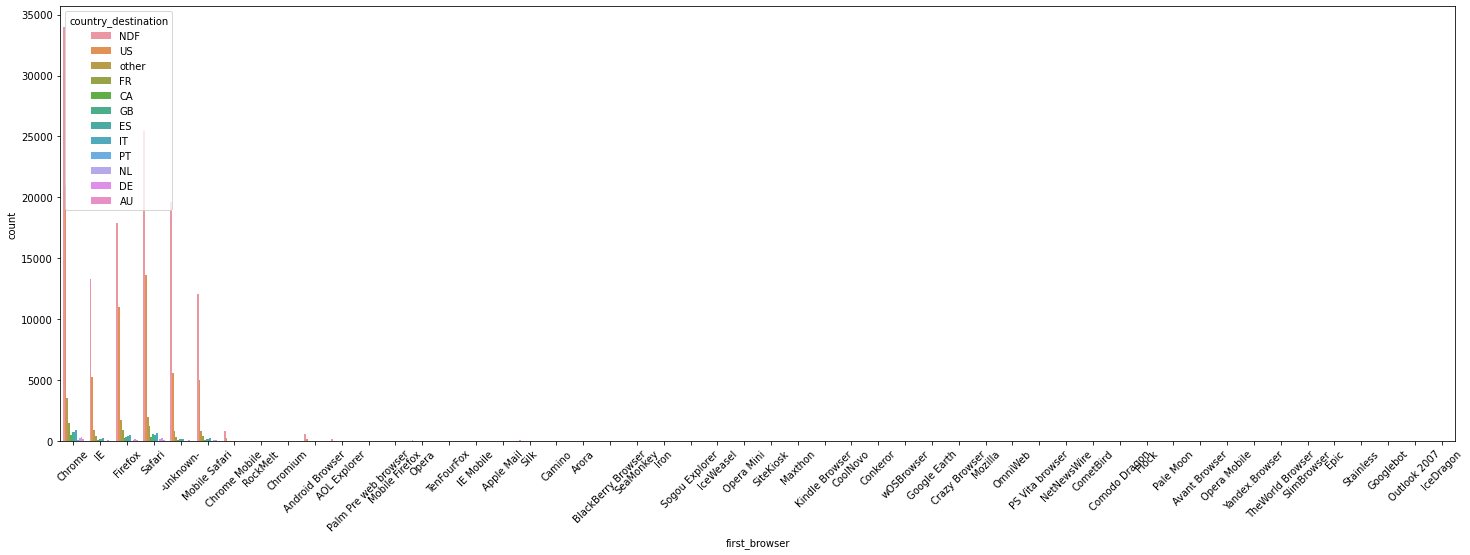

In [28]:
plt.figure(figsize=(25, 8))
sns.countplot(x=train_df['first_browser'], hue='country_destination',
              data=train_df)
plt.xticks(rotation=45)

* '-unknown-' => np.nan으로 변경한다.

In [29]:
train_df.loc[train_df['first_browser'] == '-unknown-'] = np.nan
test_df.loc[test_df['first_browser'] == '-unknown-'] = np.nan

In [30]:
print(" train first_browser : ", train_df.first_browser.unique())
print()
print(" train first_browser : ", test_df.first_browser.unique())

 train first_browser :  ['Chrome' 'IE' 'Firefox' 'Safari' nan 'Mobile Safari' 'Chrome Mobile'
 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Mobile Firefox' 'Opera' 'TenFourFox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Maxthon'
 'Kindle Browser' 'CoolNovo' 'Conkeror' 'wOSBrowser' 'Google Earth'
 'Crazy Browser' 'Mozilla' 'OmniWeb' 'PS Vita browser' 'NetNewsWire'
 'CometBird' 'Comodo Dragon' 'Flock' 'Pale Moon' 'Avant Browser'
 'Opera Mobile' 'Yandex.Browser' 'TheWorld Browser' 'SlimBrowser' 'Epic'
 'Stainless' 'Googlebot' 'Outlook 2007' 'IceDragon']

 train first_browser :  ['Mobile Safari' 'Chrome' 'IE' 'Safari' nan 'Firefox' 'Chrome Mobile'
 'Android Browser' 'IE Mobile' 'BlackBerry Browser' 'Opera' 'Silk'
 'Mobile Firefox' 'AOL Explorer' 'SeaMonkey' 'Opera Mobile' 'wOSBrowser'
 'Chromium' 'Apple Mail' 'Maxthon' 'IBrowse' 'Sogou Explorer' 'Iron'
 

### [6] date_account_created

In [31]:
train_df["date_account_created"]

0         2010-06-28
1         2011-05-25
2         2010-09-28
3         2011-12-05
4         2010-09-14
             ...    
213446    2014-06-30
213447    2014-06-30
213448    2014-06-30
213449    2014-06-30
213450           NaN
Name: date_account_created, Length: 213451, dtype: object

In [32]:
# train_df["date_account_created"] => datetime으로 변경
train_df["date_account_created"] = pd.to_datetime(train_df.date_account_created, format='%Y-%m-%d')
train_df["date_account_created"]

0        2010-06-28
1        2011-05-25
2        2010-09-28
3        2011-12-05
4        2010-09-14
            ...    
213446   2014-06-30
213447   2014-06-30
213448   2014-06-30
213449   2014-06-30
213450          NaT
Name: date_account_created, Length: 213451, dtype: datetime64[ns]

In [33]:
# train_df["date_account_created"] => datetime으로 변경
test_df["date_account_created"] = pd.to_datetime(test_df.date_account_created, format='%Y-%m-%d')
test_df["date_account_created"]

0       2014-07-01
1       2014-07-01
2       2014-07-01
3       2014-07-01
4       2014-07-01
           ...    
62091   2014-09-30
62092          NaT
62093   2014-09-30
62094   2014-09-30
62095   2014-09-30
Name: date_account_created, Length: 62096, dtype: datetime64[ns]

In [34]:
print("train date_account_created : ", len(train_df['date_account_created'])) # 213451
print("test date_account_created : ", len(test_df['date_account_created'])) # 62096

train date_account_created :  213451
test date_account_created :  62096


In [35]:
print("train null date_account_created : ", train_df['date_account_created'].isnull().sum()) # 27266
print("test null date_account_created : ", test_df['date_account_created'].isnull().sum()) # 17128

train null date_account_created :  27266
test null date_account_created :  17128


In [36]:
print("train not null date_account_created : ", len(train_df['date_account_created']) - train_df['date_account_created'].isnull().sum()) # 27266
print("test not null date_account_created : ", len(test_df['date_account_created']) - test_df['date_account_created'].isnull().sum()) # 17128

train not null date_account_created :  186185
test not null date_account_created :  44968


* 날짜를 encoding 하기 어려우니까 이 값을 년,월,일로 나눠 저장한다

In [37]:
train_df['sign_up_year'] = train_df.date_account_created.dt.year
train_df['sign_up_month'] = train_df.date_account_created.dt.month
train_df['sign_up_day'] = train_df.date_account_created.dt.day

train_df.drop('date_account_created', axis=1, inplace=True)

In [38]:
test_df['sign_up_year'] = test_df.date_account_created.dt.year
test_df['sign_up_month'] = test_df.date_account_created.dt.month
test_df['sign_up_day'] = test_df.date_account_created.dt.day

test_df.drop('date_account_created', axis=1, inplace=True)

### [7] timestamp_first_active

In [39]:
train_df["timestamp_first_active"]

0         2.009032e+13
1         2.009052e+13
2         2.009061e+13
3         2.009103e+13
4         2.009121e+13
              ...     
213446    2.014063e+13
213447    2.014063e+13
213448    2.014063e+13
213449    2.014063e+13
213450             NaN
Name: timestamp_first_active, Length: 213451, dtype: float64

In [40]:
# train_df["timestamp_first_active"] => datetime으로 변경
train_df["timestamp_first_active"] = pd.to_datetime(train_df.timestamp_first_active.astype(str).str[:8])
train_df["timestamp_first_active"]

0        2009-03-19
1        2009-05-23
2        2009-06-09
3        2009-10-31
4        2009-12-08
            ...    
213446   2014-06-30
213447   2014-06-30
213448   2014-06-30
213449   2014-06-30
213450          NaT
Name: timestamp_first_active, Length: 213451, dtype: datetime64[ns]

In [41]:
# test_df["timestamp_first_active"] => datetime으로 변경
test_df["timestamp_first_active"] = pd.to_datetime(test_df.timestamp_first_active.astype(str).str[:8])
test_df["timestamp_first_active"]

0       2014-07-01
1       2014-07-01
2       2014-07-01
3       2014-07-01
4       2014-07-01
           ...    
62091   2014-09-30
62092          NaT
62093   2014-09-30
62094   2014-09-30
62095   2014-09-30
Name: timestamp_first_active, Length: 62096, dtype: datetime64[ns]

In [42]:
print("train timestamp_first_active : ", len(train_df['timestamp_first_active'])) # 213451
print("test timestamp_first_active : ", len(test_df['timestamp_first_active'])) # 62096

train timestamp_first_active :  213451
test timestamp_first_active :  62096


In [43]:
print("train null timestamp_first_active : ", train_df['timestamp_first_active'].isnull().sum()) # 27266
print("test null timestamp_first_active : ", test_df['timestamp_first_active'].isnull().sum()) # 17128

train null timestamp_first_active :  27266
test null timestamp_first_active :  17128


In [44]:
print("train not null timestamp_first_active : ", len(train_df['timestamp_first_active']) - train_df['timestamp_first_active'].isnull().sum()) # 27266
print("test not null timestamp_first_active : ", len(test_df['timestamp_first_active']) - test_df['timestamp_first_active'].isnull().sum()) # 17128

train not null timestamp_first_active :  186185
test not null timestamp_first_active :  44968


In [45]:
temp_df = train_df[train_df['timestamp_first_active'].isnull()]
temp_df

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,sign_up_year,sign_up_month,sign_up_day
11,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213429,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213436,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213437,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213438,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* date_account_created가 null이면 timestamp_first_active도 null => 그래서 null 수 동일
* date_account_created가 null이면, 나머지 속성도 null => 모두 drop하기!

In [46]:
train_df = train_df[~train_df['timestamp_first_active'].isnull()]
test_df = test_df[~test_df['timestamp_first_active'].isnull()]

In [47]:
print("train not null timestamp_first_active : ", len(train_df['timestamp_first_active']) - train_df['timestamp_first_active'].isnull().sum()) # 186185
print("test not null timestamp_first_active : ", len(test_df['timestamp_first_active']) - test_df['timestamp_first_active'].isnull().sum()) # 44968

train not null timestamp_first_active :  186185
test not null timestamp_first_active :  44968


In [48]:
print("train null timestamp_first_active : ", train_df['timestamp_first_active'].isnull().sum()) # 27266
print("test null timestamp_first_active : ", test_df['timestamp_first_active'].isnull().sum()) # 17128

train null timestamp_first_active :  0
test null timestamp_first_active :  0


In [49]:
# Split active timestamp into year, month, day
train_df['active_year'] = train_df.timestamp_first_active.dt.year
train_df['active_month'] = train_df.timestamp_first_active.dt.month
train_df['active_day'] = train_df.timestamp_first_active.dt.day

train_df.drop('timestamp_first_active', axis=1, inplace=True)

In [50]:
# Split active timestamp into year, month, day
test_df['active_year'] = test_df.timestamp_first_active.dt.year
test_df['active_month'] = test_df.timestamp_first_active.dt.month
test_df['active_day'] = test_df.timestamp_first_active.dt.day

test_df.drop('timestamp_first_active', axis=1, inplace=True)

### [8] language

In [51]:
lang = train_df.groupby(['language','country_destination']).id.count().reset_index()

Text(0, -2, 'Where do they go for their 1st trip of different countries?')

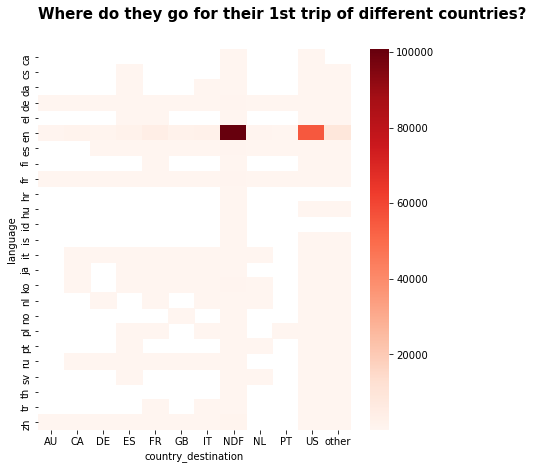

In [52]:
plt.figure(figsize=(7, 7))
fig = sns.heatmap(lang.pivot_table(values='id',index='language',columns='country_destination',aggfunc='sum'), cmap='Reds')
plt.text(0, -2,"Where do they go for their 1st trip of different countries?", \
         family='sans-serif', fontsize=15, weight='bold')

In [53]:
train_df.language.value_counts(sort=True)

en    179959
zh      1364
fr      1069
es       801
de       653
ko       611
it       449
ru       339
pt       214
ja       210
sv       110
nl        88
tr        56
pl        53
da        51
cs        28
no        26
th        22
id        21
el        19
hu        18
fi        13
is         5
ca         4
hr         2
Name: language, dtype: int64

In [54]:
train_df.isnull().sum()

id                             0
gender                         0
age                        75216
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
sign_up_year                   0
sign_up_month                  0
sign_up_day                    0
active_year                    0
active_month                   0
active_day                     0
dtype: int64

### [9] id 제거

* test_df는 id 제거 안한다 => 나중에 submission을 위해 남겨둬야 한다!

In [55]:
train_df.drop("id", axis=1, inplace=True)

## 정수 인코딩 - 임베딩

In [56]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

gender                         0
age                        75216
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
sign_up_year                   0
sign_up_month                  0
sign_up_day                    0
active_year                    0
active_month                   0
active_day                     0
dtype: int64
id                             0
gender                         0
age                        19943
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                 

* train_df, test_df를 data cleaning 한 후, 결과를 보자.

* y = country_destination

* 문자열 속성 값 : gender, signup_method, language, affiliate_channel, affiliate_provider, first_affiliate_tracked,
                signup_app, first_device_type, first_browser
                
                => 문자열 속성 값은 one-hot encoding 진행
                
* 정수 속성 값 : age, singup_flow, sign_up_year, sign_up_month, sign_up_day, active_year, active_month, active_day

In [57]:
train_df

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day
0,OTHER,NaN,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010.0,6.0,28.0,2009,3,19
1,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011.0,5.0,25.0,2009,5,23
2,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010.0,9.0,28.0,2009,6,9
3,FEMALE,42.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011.0,12.0,5.0,2009,10,31
4,OTHER,41.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010.0,9.0,14.0,2009,12,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213445,FEMALE,23.0,basic,0.0,en,sem-brand,google,omg,Web,Windows Desktop,IE,US,2014.0,6.0,30.0,2014,6,30
213446,MALE,32.0,basic,0.0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,2014.0,6.0,30.0,2014,6,30
213447,OTHER,NaN,basic,0.0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,2014.0,6.0,30.0,2014,6,30
213448,OTHER,32.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,2014.0,6.0,30.0,2014,6,30


In [58]:
test_df

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day
0,5uwns89zht,FEMALE,35.0,facebook,0.0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,2014.0,7.0,1.0,2014,7,1
1,jtl0dijy2j,OTHER,NaN,basic,0.0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,2014.0,7.0,1.0,2014,7,1
2,xx0ulgorjt,OTHER,NaN,basic,0.0,en,direct,direct,linked,Web,Windows Desktop,Chrome,2014.0,7.0,1.0,2014,7,1
3,6c6puo6ix0,OTHER,NaN,basic,0.0,en,direct,direct,linked,Web,Windows Desktop,IE,2014.0,7.0,1.0,2014,7,1
4,czqhjk3yfe,OTHER,NaN,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Safari,2014.0,7.0,1.0,2014,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62090,8yvhec201j,OTHER,NaN,basic,0.0,en,seo,yahoo,linked,Web,Windows Desktop,Chrome,2014.0,9.0,30.0,2014,9,30
62091,cv0na2lf5a,OTHER,31.0,basic,0.0,en,direct,direct,untracked,Web,Windows Desktop,IE,2014.0,9.0,30.0,2014,9,30
62093,fa6260ziny,OTHER,NaN,basic,0.0,de,direct,direct,linked,Web,Windows Desktop,Firefox,2014.0,9.0,30.0,2014,9,30
62094,87k0fy4ugm,OTHER,NaN,basic,0.0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,2014.0,9.0,30.0,2014,9,30


#### 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환

* [방법 1] : from sklearn.preprocessing import LabelEncoder
    
    => (ex) le.fit_transform(train['Sex']) => 정수로 인덱싱
           
           # array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
            #        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
            #        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
            #        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
            #        0, 1, 1, 1, 1.... 1, 1])
    => le.inverse_transform(result)를 통해 역 변환 가능!
    
* [방법 2] : get_dummies

    => get_dummies는 원핫인코딩을 매우 쉽게 해준다.
    => category형 데이터 컬럼을 선택하여 자동으로 원핫인코딩을 해준다.
    => (ex) pd.get_dummies(train['Sex'])
    
            female과 male 컬럼 생성

In [59]:
# Create categorical columns => 문자열 속성(one-hot encoding)
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

#### [방법 1] - LabelEncoder() 이용

* method1_train_df = train_df
* method1_test_df = test_df

In [60]:
from sklearn.preprocessing import LabelEncoder

In [61]:
method1_train_df = train_df.copy()
method1_test_df = test_df.copy()

In [62]:
le = LabelEncoder()

for categorical_feature in categorical_features:
    method1_train_df[categorical_feature] = method1_train_df[categorical_feature].astype('category')
for categorical_feature in categorical_features:
    method1_test_df[categorical_feature] = method1_test_df[categorical_feature].astype('category') 

In [63]:
le = LabelEncoder()

for categorical_feature in categorical_features:
    method1_train_df[categorical_feature] = le.fit_transform(method1_train_df[categorical_feature])
    
for categorical_feature in categorical_features:
    method1_test_df[categorical_feature] = le.fit_transform(method1_test_df[categorical_feature])

In [64]:
method1_train_df

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day
0,2,NaN,1,0,5,2,4,6,2,3,7,NDF,2010.0,6.0,28.0,2009,3,19
1,1,38.0,1,0,5,7,8,6,2,3,7,NDF,2011.0,5.0,25.0,2009,5,23
2,0,56.0,0,3,5,2,4,6,2,6,20,US,2010.0,9.0,28.0,2009,6,9
3,0,42.0,1,0,5,2,4,6,2,3,16,other,2011.0,12.0,5.0,2009,10,31
4,2,41.0,0,0,5,2,4,6,2,3,7,US,2010.0,9.0,14.0,2009,12,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213445,0,23.0,0,0,5,5,8,3,2,6,20,US,2014.0,6.0,30.0,2014,6,30
213446,1,32.0,0,0,5,5,8,3,2,3,40,NDF,2014.0,6.0,30.0,2014,6,30
213447,2,NaN,0,0,5,2,4,0,2,6,7,NDF,2014.0,6.0,30.0,2014,6,30
213448,2,32.0,0,0,5,2,4,6,2,3,16,NDF,2014.0,6.0,30.0,2014,6,30


In [65]:
method1_test_df

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day
0,5uwns89zht,0,35.0,1,0,6,1,4,6,1,8,16,2014.0,7.0,1.0,2014,7,1
1,jtl0dijy2j,2,NaN,0,0,6,1,4,6,1,8,16,2014.0,7.0,1.0,2014,7,1
2,xx0ulgorjt,2,NaN,0,0,6,1,4,0,2,6,4,2014.0,7.0,1.0,2014,7,1
3,6c6puo6ix0,2,NaN,0,0,6,1,4,0,2,6,10,2014.0,7.0,1.0,2014,7,1
4,czqhjk3yfe,2,NaN,0,0,6,1,4,6,2,3,22,2014.0,7.0,1.0,2014,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62090,8yvhec201j,2,NaN,0,0,6,6,15,0,2,6,4,2014.0,9.0,30.0,2014,9,30
62091,cv0na2lf5a,2,31.0,0,0,6,1,4,6,2,6,10,2014.0,9.0,30.0,2014,9,30
62093,fa6260ziny,2,NaN,0,0,4,1,4,0,2,6,8,2014.0,9.0,30.0,2014,9,30
62094,87k0fy4ugm,2,NaN,0,0,6,4,8,3,2,3,22,2014.0,9.0,30.0,2014,9,30


* 이 방식을 사용하면 아래 결과에서 아시다시피, 따로 추가 작업 x

In [66]:
train_col = set(method1_train_df.columns.tolist())
test_col = set(method1_test_df.columns.tolist())
print(train_col - test_col)
print()
print(test_col - train_col)

{'country_destination'}

{'id'}


#### [방법 2] - get dummies 이용

* method2_train_df = train_df
* method2_test_df = test_df

In [67]:
method2_train_df = train_df.copy()
method2_test_df = test_df.copy()

In [68]:
train_col = set(method2_train_df.columns.tolist())
test_col = set(method2_test_df.columns.tolist())
print(train_col - test_col - {'country_destination'})
print(len(train_col - test_col - {'country_destination'}))
print()
print(test_col - train_col - {'id'})
print(len(test_col - train_col - {'id'}))

set()
0

set()
0


In [69]:
  
# get dummies => one_hot encoding과 동일하게 만들어 준다
for categorical_feature in categorical_features:
    df_all_dummy = pd.get_dummies(method2_train_df[categorical_feature], prefix=categorical_feature)
    method2_train_df = method2_train_df.drop([categorical_feature], axis=1)
    method2_train_df = pd.concat((method2_train_df, df_all_dummy), axis=1)
    
# get dummies => one_hot encoding과 동일하게 만들어 준다
for categorical_feature in categorical_features:
    df_all_dummy = pd.get_dummies(method2_test_df[categorical_feature], prefix=categorical_feature)
    method2_test_df = method2_test_df.drop([categorical_feature], axis=1)
    method2_test_df = pd.concat((method2_test_df, df_all_dummy), axis=1)

In [70]:
method2_train_df

,age,country_destination,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day,affiliate_channel_api,affiliate_channel_content,...,signup_flow_8.0,signup_flow_10.0,signup_flow_12.0,signup_flow_15.0,signup_flow_16.0,signup_flow_20.0,signup_flow_21.0,signup_flow_23.0,signup_flow_24.0,signup_flow_25.0
0,NaN,NDF,2010.0,6.0,28.0,2009,3,19,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,NDF,2011.0,5.0,25.0,2009,5,23,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,US,2010.0,9.0,28.0,2009,6,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,other,2011.0,12.0,5.0,2009,10,31,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,US,2010.0,9.0,14.0,2009,12,8,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213445,23.0,US,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213446,32.0,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213447,NaN,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213448,32.0,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
method2_test_df

,id,age,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day,affiliate_channel_content,affiliate_channel_direct,...,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0.0,signup_flow_8.0,signup_flow_12.0,signup_flow_14.0,signup_flow_21.0,signup_flow_23.0,signup_flow_25.0
0,5uwns89zht,35.0,2014.0,7.0,1.0,2014,7,1,0,1,...,1,0,0,1,0,0,0,0,0,0
1,jtl0dijy2j,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,xx0ulgorjt,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,6c6puo6ix0,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,czqhjk3yfe,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62090,8yvhec201j,NaN,2014.0,9.0,30.0,2014,9,30,0,0,...,0,0,0,1,0,0,0,0,0,0
62091,cv0na2lf5a,31.0,2014.0,9.0,30.0,2014,9,30,0,1,...,0,0,0,1,0,0,0,0,0,0
62093,fa6260ziny,NaN,2014.0,9.0,30.0,2014,9,30,0,1,...,0,0,0,1,0,0,0,0,0,0
62094,87k0fy4ugm,NaN,2014.0,9.0,30.0,2014,9,30,0,0,...,0,0,0,1,0,0,0,0,0,0


* 이 방식을 사용할거면 애초에 train+test를 합쳐서 전체로 데이터 전처리 과정 진행 후에, 나중에 split해야 함
* 지금은 그렇게 못했으니까 임의의 열 속성 추가해서 채워 준다

=> train 기준 : 필요한 속성 ('signup_flow_14.0')

=> test 기준 : 필요한 속성 ('signup_flow_24.0', 'signup_flow_4.0', 'signup_flow_20.0', 'signup_flow_5.0', 'signup_flow_3.0', 'signup_flow_2.0', 'signup_flow_1.0', 'signup_flow_15.0', 'signup_flow_16.0', 'signup_flow_6.0', 'signup_flow_10.0')

In [72]:
train_col = set(method2_train_df.columns.tolist())
test_col = set(method2_test_df.columns.tolist())
print(train_col - test_col - {'country_destination'})
print(len(train_col - test_col - {'country_destination'}))
print()
print(test_col - train_col - {'id'})
print(len(test_col - train_col - {'id'}))

{'signup_flow_16.0', 'language_hr', 'signup_flow_1.0', 'signup_flow_10.0', 'language_is', 'first_browser_CoolNovo', 'first_browser_Comodo Dragon', 'first_browser_OmniWeb', 'signup_flow_4.0', 'first_browser_Flock', 'first_browser_NetNewsWire', 'first_browser_Outlook 2007', 'first_browser_TheWorld Browser', 'first_browser_PS Vita browser', 'signup_flow_2.0', 'first_browser_Arora', 'signup_flow_3.0', 'first_browser_Epic', 'signup_flow_15.0', 'first_browser_Stainless', 'first_browser_Crazy Browser', 'first_browser_Google Earth', 'signup_flow_5.0', 'first_browser_SlimBrowser', 'first_browser_Camino', 'first_browser_Kindle Browser', 'signup_flow_6.0', 'first_browser_Palm Pre web browser', 'first_browser_Mozilla', 'first_browser_RockMelt', 'first_browser_TenFourFox', 'affiliate_provider_wayn', 'affiliate_channel_api', 'first_browser_Conkeror', 'first_browser_IceDragon', 'first_browser_Avant Browser', 'signup_flow_20.0', 'signup_flow_24.0', 'first_browser_Googlebot'}
39

{'language_-unknown-',

In [73]:
temp1 = test_col - train_col - {'id'}
temp2 = train_col - test_col - {'country_destination'}

for t in temp1:
    method2_train_df[t] = 0

for t in temp2:
    method2_test_df[t] = 0

In [74]:
method2_train_df

,age,country_destination,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day,affiliate_channel_api,affiliate_channel_content,...,signup_flow_21.0,signup_flow_23.0,signup_flow_24.0,signup_flow_25.0,language_-unknown-,signup_method_weibo,first_browser_Nintendo Browser,first_browser_UC Browser,first_browser_IBrowse,signup_flow_14.0
0,NaN,NDF,2010.0,6.0,28.0,2009,3,19,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,NDF,2011.0,5.0,25.0,2009,5,23,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,US,2010.0,9.0,28.0,2009,6,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,other,2011.0,12.0,5.0,2009,10,31,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,US,2010.0,9.0,14.0,2009,12,8,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213445,23.0,US,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213446,32.0,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213447,NaN,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213448,32.0,NDF,2014.0,6.0,30.0,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
method2_test_df

,id,age,sign_up_year,sign_up_month,sign_up_day,active_year,active_month,active_day,affiliate_channel_content,affiliate_channel_direct,...,first_browser_RockMelt,first_browser_TenFourFox,affiliate_provider_wayn,affiliate_channel_api,first_browser_Conkeror,first_browser_IceDragon,first_browser_Avant Browser,signup_flow_20.0,signup_flow_24.0,first_browser_Googlebot
0,5uwns89zht,35.0,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,jtl0dijy2j,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,xx0ulgorjt,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,6c6puo6ix0,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,czqhjk3yfe,NaN,2014.0,7.0,1.0,2014,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62090,8yvhec201j,NaN,2014.0,9.0,30.0,2014,9,30,0,0,...,0,0,0,0,0,0,0,0,0,0
62091,cv0na2lf5a,31.0,2014.0,9.0,30.0,2014,9,30,0,1,...,0,0,0,0,0,0,0,0,0,0
62093,fa6260ziny,NaN,2014.0,9.0,30.0,2014,9,30,0,1,...,0,0,0,0,0,0,0,0,0,0
62094,87k0fy4ugm,NaN,2014.0,9.0,30.0,2014,9,30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
train_col = set(method2_train_df.columns.tolist())
test_col = set(method2_test_df.columns.tolist())
print(train_col - test_col)
print()
print(test_col - train_col)

{'country_destination'}

{'id'}


#### 이제 y도 임베딩 -> 이건 그냥 le.fit_transform 이용

* method1_train_df, method2_train_df에서 먼저 결과 값 country_destination 떼어 내고 만들자

* [train data]

* method1_y = method1_train_df["country_destination"]
* method2_y = method2_train_df["country_destination"]

In [77]:
le = LabelEncoder()
method1_y = le.fit_transform(method1_train_df["country_destination"])
method2_y = le.fit_transform(method2_train_df["country_destination"])

In [78]:
method1_train_df.drop("country_destination", axis=1, inplace=True)
method2_train_df.drop("country_destination", axis=1, inplace=True)

In [79]:
method1_y

array([ 7,  7, 10, ...,  7,  7,  7])

In [80]:
method2_y

array([ 7,  7, 10, ...,  7,  7,  7])

## 데이터 세트(train, validation) split

#### 입력 데이터 확인
[method1_test_df, method2_test_df]

* X : method1_train_df, method2_train_df
* y : method1_y, method2_y

In [81]:
from sklearn.model_selection import train_test_split # 데이터 셋 분할

In [82]:
# 방법 1
X_train1, X_val1, y_train1, y_val1 = train_test_split(method1_train_df, method1_y, \
                                                      test_size=0.2, random_state=0)

# 방법 2
X_train2, X_val2, y_train2, y_val2 = train_test_split(method2_train_df, method2_y, \
                                                      test_size=0.2, random_state=0)

## 모델 선언 및 훈련

#### [1] XGboost 모델 이용

In [83]:
"""
xgb.XGBClassifier(
    # General Parameter
    booster='gbtree' # 트리,회귀(gblinear) 트리가 항상 
                     # 더 좋은 성능을 내기 때문에 수정할 필요없다고한다.
    silent=True  # running message출력안한다.
                 # 모델이 적합되는 과정을 이해하기위해선 False으로한다.
    min_child_weight=10   # 값이 높아지면 under-fitting 되는 
                          # 경우가 있다. CV를 통해 튜닝되어야 한다.
    max_depth=8     # 트리의 최대 깊이를 정의함. 
                    # 루트에서 가장 긴 노드의 거리.
                    # 8이면 중요변수에서 결론까지 변수가 9개거친다.
                    # Typical Value는 3-10. 
    gamma =0    # 노드가 split 되기 위한 loss function의 값이
                # 감소하는 최소값을 정의한다. gamma 값이 높아질 수록 
                # 알고리즘은 보수적으로 변하고, loss function의 정의
                #에 따라 적정값이 달라지기때문에 반드시 튜닝.
    nthread =4    # XGBoost를 실행하기 위한 병렬처리(쓰레드)
                  #갯수. 'n_jobs' 를 사용해라.
    colsample_bytree=0.8   # 트리를 생성할때 훈련 데이터에서 
                           # 변수를 샘플링해주는 비율. 보통0.6~0.9
    colsample_bylevel=0.9  # 트리의 레벨별로 훈련 데이터의 
                           #변수를 샘플링해주는 비율. 보통0.6~0.9
    n_estimators =(int)   #부스트트리의 양
                          # 트리의 갯수. 
    objective = 'reg:linear','binary:logistic','multi:softmax',
                'multi:softprob'  # 4가지 존재.
            # 회귀 경우 'reg', binary분류의 경우 'binary',
            # 다중분류경우 'multi'- 분류된 class를 return하는 경우 'softmax'
            # 각 class에 속할 확률을 return하는 경우 'softprob'
    random_state =  # random number seed.
                    # seed 와 동일.
)
"""

"\nxgb.XGBClassifier(\n    # General Parameter\n    booster='gbtree' # 트리,회귀(gblinear) 트리가 항상 \n                     # 더 좋은 성능을 내기 때문에 수정할 필요없다고한다.\n    silent=True  # running message출력안한다.\n                 # 모델이 적합되는 과정을 이해하기위해선 False으로한다.\n    min_child_weight=10   # 값이 높아지면 under-fitting 되는 \n                          # 경우가 있다. CV를 통해 튜닝되어야 한다.\n    max_depth=8     # 트리의 최대 깊이를 정의함. \n                    # 루트에서 가장 긴 노드의 거리.\n                    # 8이면 중요변수에서 결론까지 변수가 9개거친다.\n                    # Typical Value는 3-10. \n    gamma =0    # 노드가 split 되기 위한 loss function의 값이\n                # 감소하는 최소값을 정의한다. gamma 값이 높아질 수록 \n                # 알고리즘은 보수적으로 변하고, loss function의 정의\n                #에 따라 적정값이 달라지기때문에 반드시 튜닝.\n    nthread =4    # XGBoost를 실행하기 위한 병렬처리(쓰레드)\n                  #갯수. 'n_jobs' 를 사용해라.\n    colsample_bytree=0.8   # 트리를 생성할때 훈련 데이터에서 \n                           # 변수를 샘플링해주는 비율. 보통0.6~0.9\n    colsample_bylevel=0.9  # 트리의 레벨별로 훈련 데이터의 \n                           #

In [84]:
# 분류 문제이니까 XGBoost의 classifier 이용
from xgboost.sklearn import XGBClassifier

In [85]:
xgb = XGBClassifier(max_depth=15, learning_rate=0.1, n_estimators=100,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.5, seed=1)

In [86]:
print(len(X_train1))
print(len(y_train1))
print(len(X_val1))
print(len(y_val1))

148948
148948
37237
37237


##### * 방법1 학습

In [88]:
xgb.fit(method1_train_df, method1_y)
# 회귀 : eval_matric = rmse, 분류 : error

[02:09:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### * 방법2 학습

In [100]:
xgb2 = XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=100,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.5, seed=1)

In [101]:
xgb2.fit(method2_train_df, method2_y)
# 회귀 : eval_matric = rmse, 분류 : error

/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:13:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

## 모델을 이용해 예측

In [91]:
# y 확인
print(np.unique(method1_y))

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [92]:
# y 매핑 확인
print(le.inverse_transform(np.unique(method1_y)))

['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']


In [93]:
target_names = le.inverse_transform(np.unique(method1_y))

#### [1] 방법 1 + XGboost 모델 이용

In [96]:
from sklearn.metrics import classification_report

In [94]:
# 모델 명 : xgb

# X_val1을 이용해 예측 진행
y_pred1 = xgb.predict_proba(X_val1).argmax(axis=1)

In [95]:
print(classification_report(y_val1 , y_pred1, target_names = target_names))

              precision    recall  f1-score   support

          AU       1.00      0.02      0.04       102
          CA       1.00      0.06      0.11       280
          DE       1.00      0.04      0.08       182
          ES       1.00      0.08      0.15       388
          FR       1.00      0.14      0.25       902
          GB       0.98      0.11      0.20       404
          IT       1.00      0.06      0.12       544
         NDF       0.75      0.92      0.83     21034
          NL       1.00      0.04      0.07       156
          PT       0.00      0.00      0.00        42
          US       0.69      0.66      0.67     11354
       other       0.97      0.14      0.25      1849

    accuracy                           0.74     37237
   macro avg       0.87      0.19      0.23     37237
weighted avg       0.76      0.74      0.70     37237



/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### [1] 방법 2 + XGboost 모델 이용

In [102]:
# 모델 명 : xgb2

# X_val2을 이용해 예측 진행
y_pred2 = xgb2.predict_proba(X_val2).argmax(axis=1)

In [103]:
print(classification_report(y_val2 , y_pred2, target_names = target_names))

              precision    recall  f1-score   support

          AU       1.00      0.05      0.09       102
          CA       1.00      0.16      0.27       280
          DE       1.00      0.13      0.23       182
          ES       0.99      0.28      0.44       388
          FR       1.00      0.34      0.51       902
          GB       0.99      0.25      0.41       404
          IT       1.00      0.21      0.35       544
         NDF       0.81      0.96      0.88     21034
          NL       1.00      0.08      0.14       156
          PT       0.00      0.00      0.00        42
          US       0.81      0.77      0.79     11354
       other       1.00      0.36      0.53      1849

    accuracy                           0.82     37237
   macro avg       0.88      0.30      0.39     37237
weighted avg       0.83      0.82      0.80     37237



/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 사실 kaggle reference 코드들은 xgboost의 파라미터 값이 굉장히 작다
    => 그렇기 때문에 이 결과가 좋다고 볼 수 있는지 모르겠당

## Kaggle submission

TEST DATA이용

* [method1_test_df, method2_test_df]

In [106]:
predictionsxgb=xgb.predict(method1_test_df.drop(['id'],axis=1))

resultsxgb=[]
for i in predictionsxgb:
    resultsxgb.append(target_names[i])

In [107]:
my_submissionxgb = pd.DataFrame({'id': method1_test_df.id, 'country':resultsxgb})

In [108]:
my_submissionxgb.to_csv('submissionxgb1.csv', index=False)

In [110]:
predictionsxgb=xgb2.predict(method2_test_df.drop(['id'],axis=1))

resultsxgb=[]
for i in predictionsxgb:
    resultsxgb.append(target_names[i])

In [111]:
my_submissionxgb = pd.DataFrame({'id': method2_test_df.id, 'country':resultsxgb})

In [112]:
my_submissionxgb.to_csv('submissionxgb2.csv', index=False)